In [1]:
import numpy as np

from qiskit.circuit import Parameter
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import Operator, SparsePauliOp
from qiskit.visualization import circuit_drawer, plot_histogram

import sys
sys.path.append("..")
from vqe_algorithm import *

In [2]:
# Creamos el Hamiltoniano del OAS tridimensional

def create_annihilation_operator(d):
    a = np.zeros((d, d))
    for n in range(1, d):
        a[n-1, n] = np.sqrt(n)
    return a

d_mode = 2
d_total = d_mode ** 3

a = create_annihilation_operator(d_mode)
adag = a.T
I = np.eye(d_mode)


a_x = np.kron(np.kron(a, I), I)
a_y = np.kron(np.kron(I, a), I)
a_z = np.kron(np.kron(I, I), a)

adag_x = a_x.T
adag_y = a_y.T
adag_z = a_z.T

n_x = adag_x @ a_x
n_y = adag_y @ a_y
n_z = adag_z @ a_z

H_matrix = n_x + n_y + n_z + 1.5 * np.eye(d_total)

# Lo expresamos como combinación de cadenas de Pauli
hamiltonian = SparsePauliOp.from_operator(Operator(H_matrix))
print(hamiltonian)

SparsePauliOp(['III', 'IIZ', 'IZI', 'ZII'],
              coeffs=[ 3. +0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j])


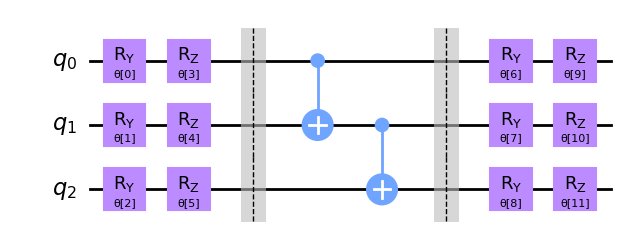

In [3]:
# Generamos un ansatz EfficientSU2 de 3 cúbits

theta = Parameter("θ")
ansatz = EfficientSU2(
    num_qubits=3,
    entanglement='linear',
    reps=1,
    insert_barriers=True
)

circuit_drawer(
    ansatz.decompose(),
    output='mpl',
    filename='images/ansatz_efficientsu2.png',
    style='clifford'
)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 1.5000000041025268
       x: [-6.489e-05 -1.313e-05  3.787e-05  1.250e-01  0.000e+00
            0.000e+00  5.260e-05 -2.420e-05 -2.882e-05  0.000e+00
            0.000e+00  0.000e+00]
    nfev: 110
   maxcv: 0.0


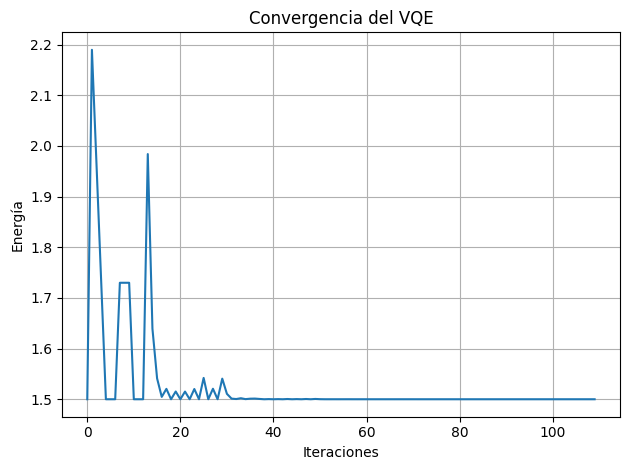

<IPython.core.display.Latex object>

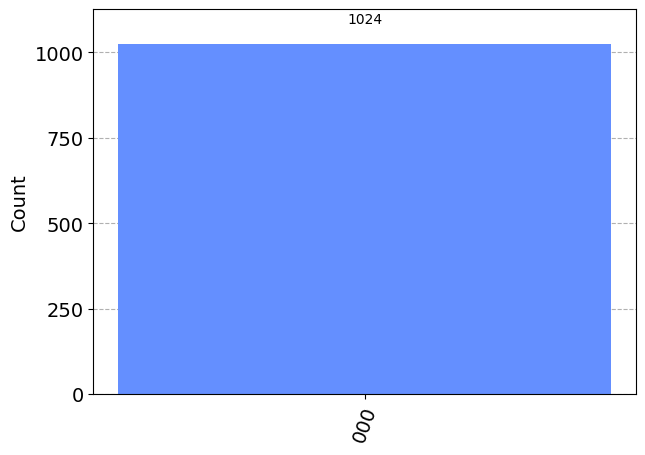

In [4]:
# Aplicamos el VQE
result, cost_history = run_vqe(ansatz, hamiltonian)

# Representamos la evolución de la energía durante la optimización
print(result)
plot_cost_history(cost_history, "cost_history_oas_3d")

# Obtenemos el estado cuántico
sv = get_statevector(ansatz, result["x"])
display(sv.draw('latex'))

# Simulamos la medición del circuito con parámetors óptimos y representamos el histograma
counts = simulate_measurement(ansatz, result["x"])
fig = plot_histogram(counts)
fig.figure.savefig("images/histogram_counts_oas_3d.png")
display(fig)

In [5]:
# Aplicamos el VQD para obtener las energía superiores

result = run_vqd(hamiltonian, ansatz, k=5)
result.eigenvalues

array([1.50000001+0.j, 2.50001746+0.j, 2.50090062+0.j, 2.50342801+0.j,
       3.50178516+0.j])